# Members : Mohammed Uddin, Jason Charles, Moshe Klein

# Loading Data, visual, and preprocessing

to-do-list:

Data Augmentation: Consider using data augmentation to improve the model's robustness. (TensorFlow offers tools like tf.keras.layers.experimental.preprocessing for real-time data augmentation.)

Advanced Preprocessing: Might need more advanced preprocessing. For brain tumor images, consider techniques like histogram equalization or advanced filtering.

Model Architecture: Define a robust model architecture. For medical images, architectures like U-Net or pretrained models like ResNet can be effective.

Custom Metrics and Callbacks: Depending on the nature of the data, we might need to define custom metrics (like F1-score, sensitivity, specificity) and callbacks (like early stopping, model checkpointing).

Validation Strategy: Ensure a robust validation strategy. Cross-validation might be more suitable for medical datasets due to their usually small size.

Explainability: Given the medical nature of the task, model explainability is crucial. Tools like Grad-CAM can be helpful in understanding model decisions.

**Some notes about the data:**


*   Some of the images seem to be dark
*   They do have 3 channels
*   Keep in mind not to make huge changes in the data augmentation (MRI images are standardized already)
*   There are 4 classes to predict



In [ ]:
!unzip /content/BrainTumorML.zip

In [ ]:
# For Data Processing
import os
import shutil
import numpy as np
import pathlib
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



# For Data Visualization
import matplotlib.pyplot as plt

In [ ]:
training_path="/content/BrainTumorML/Training"
test_path="/content/BrainTumorML/Testing"

training_folder=os.listdir(training_path)
print(training_folder)

['glioma', 'notumor', 'pituitary', 'meningioma']


In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
#training, validation and test sets

train_ds = tf.keras.utils.image_dataset_from_directory(
  training_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
print(class_names)
print(len(train_ds))

# 143 batches. 143 * 32 is about 4570

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
['glioma', 'meningioma', 'notumor', 'pituitary']
143


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  training_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    shuffle=False,
    image_size=(img_height, img_width),
)

len(test_ds)

Found 1311 files belonging to 4 classes.


41

0.0 255.0
0.0 255.0
0.0 255.0
0.0 255.0
0.0 255.0
0.0 255.0
0.0 255.0
0.0 255.0
0.0 255.0


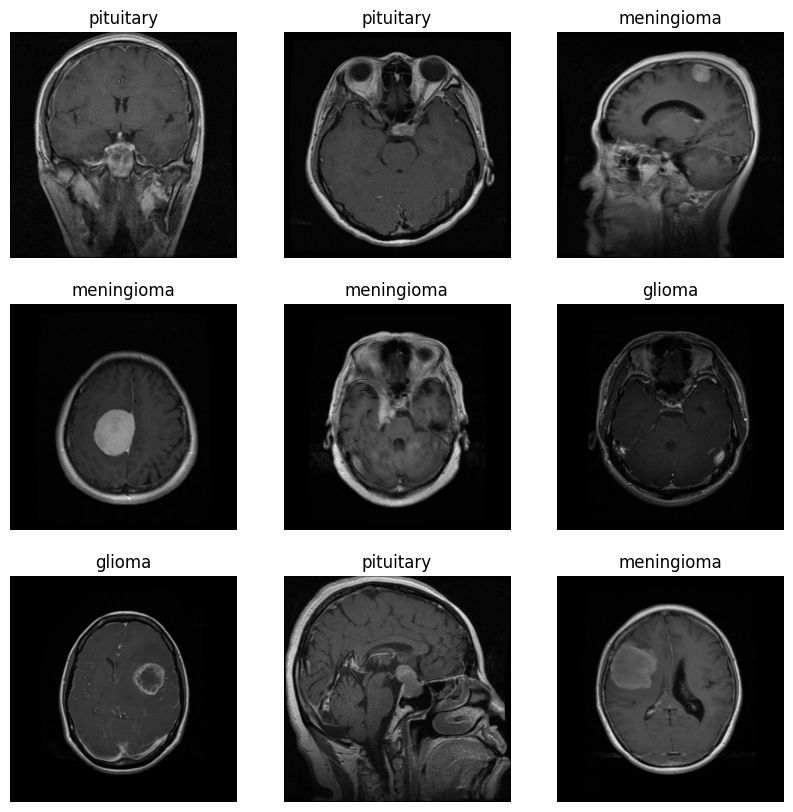

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    print(np.min(images), np.max(images))

# Standardization

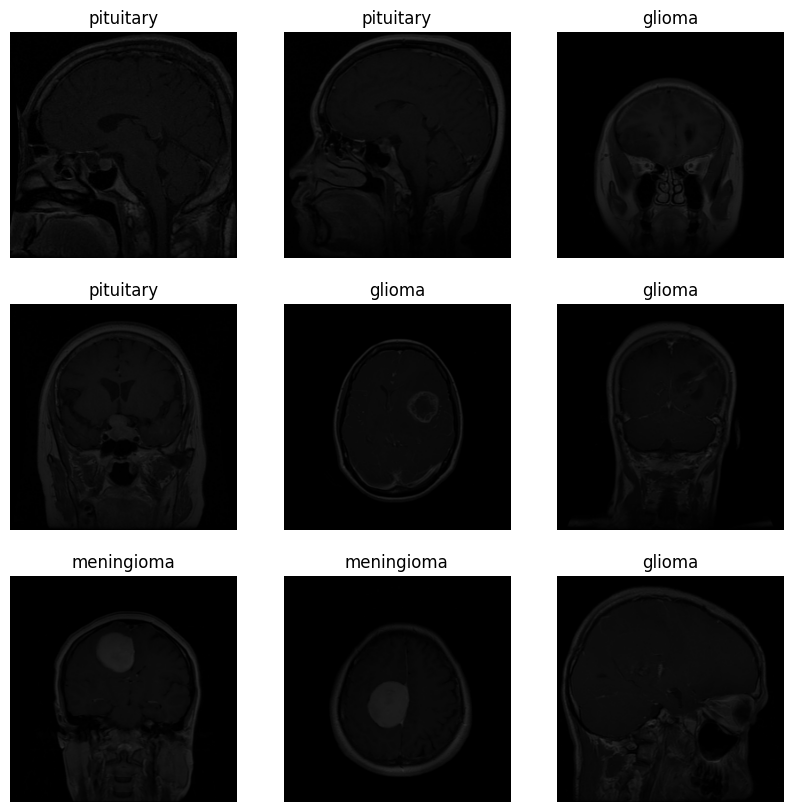

In [ ]:
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Map the normalization layer to the dataset
# use later to see what is actually happening to the images
visual_train_ds = train_ds.map(lambda x, y: (rescale_layer(x), y))

# Plot 9 images from the normalized dataset
plt.figure(figsize=(10, 10))
for images, labels in visual_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # Scale up the pixel values for visualization
        scaled_image = (images[i].numpy() * 50).astype("uint8")

        plt.imshow(scaled_image)
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Data Augmentation

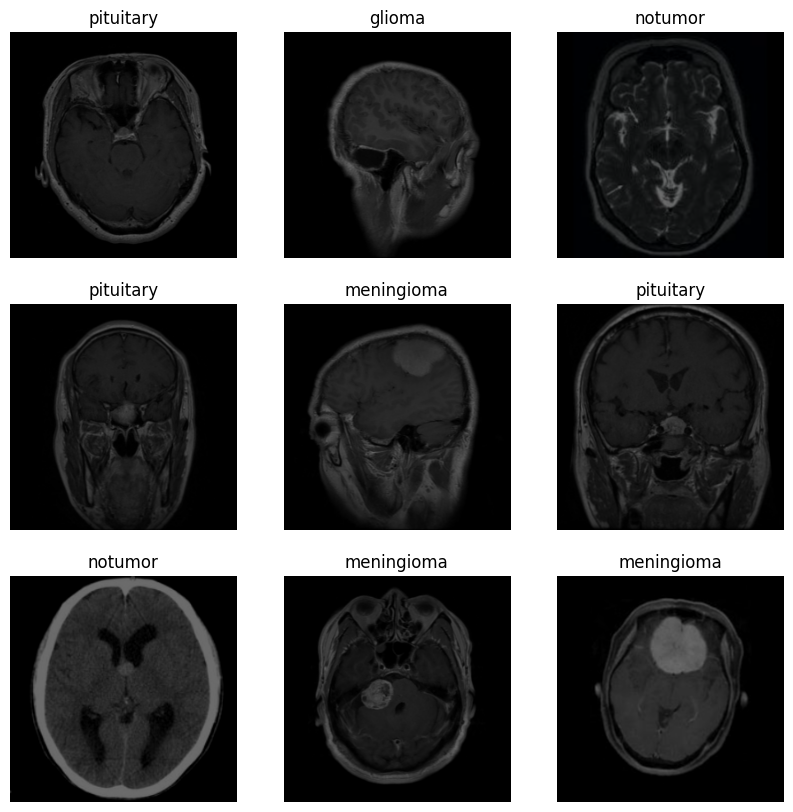

In [ ]:
# Data Augmentation layer
# apply very small changes since mri images themselves are very standardized
# zooms seems to distort the images
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2, input_shape=(img_height,img_width,3)),
  tf.keras.layers.experimental.preprocessing.RandomZoom(1/1000),
  tf.keras.layers.experimental.preprocessing.RandomRotation(1/1000),

])

# takes the set made previously in the standardization,
# just to make a visual of what the images would look like after everything
visual_train_ds= visual_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

plt.figure(figsize=(10, 10))
for images, labels in visual_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # Scale up the pixel values for visualization
    scaled_image = (images[i].numpy() * 100).astype("uint8")
    plt.imshow(scaled_image)
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Custom Metrics



In [ ]:
from tensorflow.keras.metrics import Metric
from tensorflow.keras.initializers import Zeros

class Sensitivity(Metric):
    def __init__(self, name='sensitivity', **kwargs):
        super(Sensitivity, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer=Zeros(), dtype=tf.float32)
        self.actual_positives = self.add_weight(name='ap', initializer=Zeros(), dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        true_pos = tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1))
        self.true_positives.assign_add(tf.reduce_sum(tf.cast(true_pos, tf.float32)))
        self.actual_positives.assign_add(tf.reduce_sum(tf.cast(tf.equal(y_true, 1), tf.float32)))

    def result(self):
        return self.true_positives / (self.actual_positives + tf.keras.backend.epsilon())

class Specificity(Metric):
    def __init__(self, name='specificity', **kwargs):
        super(Specificity, self).__init__(name=name, **kwargs)
        self.true_negatives = self.add_weight(name='tn', initializer=Zeros(), dtype=tf.float32)
        self.actual_negatives = self.add_weight(name='an', initializer=Zeros(), dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        true_neg = tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 0))
        self.true_negatives.assign_add(tf.reduce_sum(tf.cast(true_neg, tf.float32)))
        self.actual_negatives.assign_add(tf.reduce_sum(tf.cast(tf.equal(y_true, 0), tf.float32)))

    def result(self):
        return self.true_negatives / (self.actual_negatives + tf.keras.backend.epsilon())


# **The Model**







In [ ]:
num_classes=len(training_folder) #4 classes

tf.random.set_seed(123)
# Define the model architecture
model = models.Sequential([

    data_augmentation,
    rescale_layer,
    # First conv block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Second conv block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third conv block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fourth conv block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flattening the output of the conv layers to feed into the dense layers
    layers.Flatten(),

    # Dense layer
    layers.Dense(512, activation='relu'),

    # Output layer
    #'softmax' for multi-class classification
    #4 outputs for 4 classes: notumor,giloma,pituitary, meningioma
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', Sensitivity(), Specificity()])

# Display the model's architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [ ]:
# Define callbacks: Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [ ]:
# Include the callbacks in the model's fit method
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


143/143 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.6967 - sensitivity: 0.7562 - specificity: 3.2817
Epoch 1: val_loss improved from inf to 0.46828, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - 26s 112ms/step - loss: 0.7487 - accuracy: 0.6967 - sensitivity: 0.7562 - specificity: 3.2817 - val_loss: 0.4683 - val_accuracy: 0.8380 - val_sensitivity: 0.9495 - val_specificity: 3.1212
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.8359 - sensitivity: 0.9424 - specificity: 3.0440
Epoch 2: val_loss improved from 0.46828 to 0.33638, saving model to best_model.h5
143/143 [==============================] - 14s 92ms/step - loss: 0.4288 - accuracy: 0.8359 - sensitivity: 0.9424 - specificity: 3.0440 - val_loss: 0.3364 - val_accuracy: 0.8757 - val_sensitivity: 0.9697 - val_specificity: 3.0087
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.8847 - sensitivity: 0.9722 - specificity: 3.0257
Epoch 3: val_loss improved from 0.33638 to 0.31096, saving model to best_model.h5
143/143 [==============================] - 14s 92ms/step - loss: 0.2968 - accuracy: 0.8847 - sens

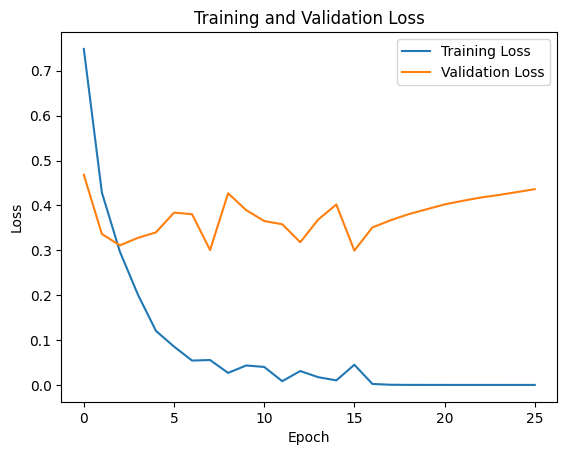

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Seems sort of concerning that the model learned so quick. It seems the validation loss didn't change as much as the training loss

# Test Model on Test Set

In [ ]:

predictions = model.predict(test_ds)

# Convert the predicted probabilities to class predictions
predicted_classes = np.argmax(predictions, axis=1)

# Print the predicted classes
print("Predicted classes:", predicted_classes)

41/41 [==============================] - 2s 48ms/step
Predicted classes: [0 0 0 ... 3 3 3]


0.0 248.5
0.0 248.5
0.0 248.5
0.0 248.5
0.0 248.5
0.0 248.5
0.0 248.5
0.0 248.5
0.0 248.5


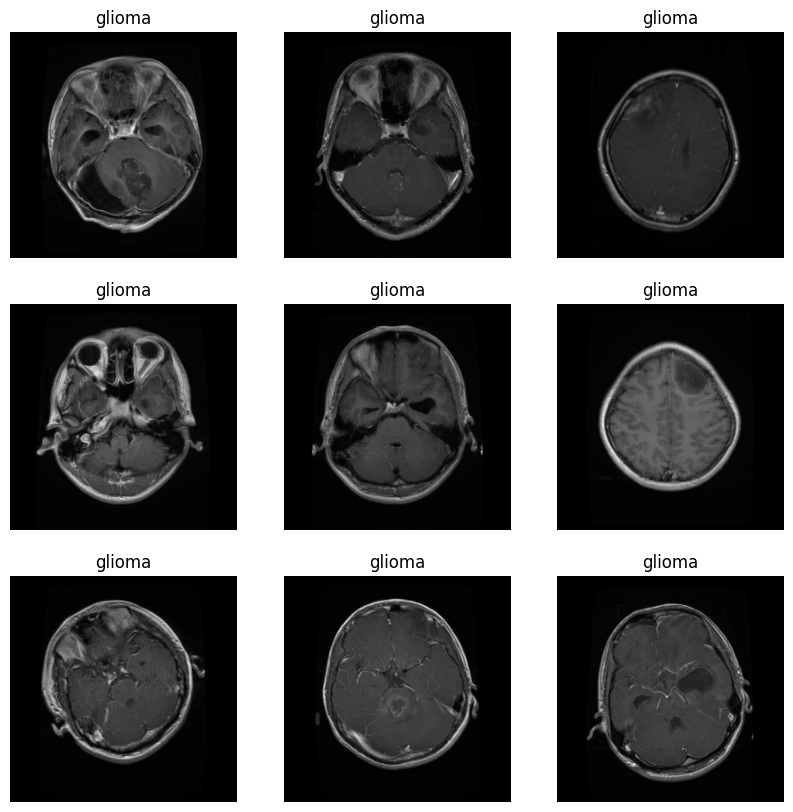

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    print(np.min(images), np.max(images))

Predictions on the test set seem right. We know the first couple hundred images are from giloma and the last couple hundred are from pituitary.

# LAB-REPORT:

### **1**. Introduction: Describe the problem you are trying to solve with machine learning. What is your machine learning question, and why is it important? How is it helpful for machines to answer the question?

  **1A:**
    
  Our Machine Learning quesition is, can an ML model predict whether a tumor is present in an image of a brain. We want to have our model identify specific brain tumors, including glioma, meningioma, and pituitary by learning from a vast dataset of brain images.
  This is important because it will allow doctors, radiologists and other healthcare professionals to focus on problems that machine learning cannot yet solve. The model will help patients to be diagnosed with more accuracy in a smaller window of time as a result.
  This is a meaningful effort to us as a group beacause of our personal experiences with cancer. We've had family members and even ourselves be affected by different types of it and would like to make strides to help progress the innovation of cancer research. In summary, it is helpful because of the variety of benefits it offers; Automation and Efficiency, Consistency, Early Detection, Aiding Healthcare Professionals, Handling workload, Resource Optimization, Accesibility, and Continous Learning.  


### 2. Method: Describe the steps you took to solve the problem. This should be of a suitable level of detail that someone else could read what you wrote and try a similar process themselves. This should include:
 * The dataset. Where did it come from and what does it contain?

 * What data cleaning and preprocessing steps did you perform?

 * What machine learning methods are you using? If you are basing your approach on some other research you found, who is it by and what did they do?
     
  **2A:**

  * The dataset came from Kaggle.com. It contains two datasets, one for training and another for testing. Each dataset contains four subdirectories of brain images. Each subdirectory contains brain images that are of the type of the name of the subdirectory. Every subdirectory contains an approximately equal amount of pictures as compared to the next.

  * For preprocessing, we used the handy utlity function TensorFlow provides for images. That is the tf.keras.utils.image_dataset_from_directory function. It made preprocessing straightforward since all we had to do was provide the path to the directory, dimensions for the images, and batch size. We also chose to do data augmentation since we could not find more images and because we thought the model should be learning from as many images as posssible. We also made the rgb channels for the images smaller so the model could process images faster (ie.scaling).

  * We have employed a convolutional neural network (CNN),specifically  for its proficiency in handling image data. The architecture of our CNN model includes a series of convolutional layers, each followed by max-pooling layers. These layers are essential for feature extraction from the brain images, capturing intricate patterns and details crucial for tumor identification.

 ###   Our model's **architecture** is structured as follows:

* a. **Convolutional Layers:** We have incorporated multiple convolutional layers. Each convolutional layer uses filters to perform convolution operations, effectively capturing features like edges and shapes in the brain images. These layers help in learning the various aspects of the images that are indicative of the presence and type of tumors.

* b. **Max-Pooling Layers:** Following each convolutional layer, a max-pooling layer is used. Max-pooling reduces the spatial dimensions of the output from the convolutional layers, which helps in reducing the computational load and the number of parameters in the model. This also aids in preventing overfitting by providing an abstracted form of the features.

* c. **Dense and Output Layers:** After the series of convolutional and max-pooling layers, the network flattens the output and feeds it into a dense layer with a significant number of neurons (we chose 512 neurons for this layer). This is followed by a softmax output layer. The softmax layer is crucial for multi-class classification, providing a probability distribution over the various tumor types we aim to classify.

* For **metrics**, we didn't just rely on accuracy. We integrated custom metrics, namely Sensitivity and Specificity, into our model's evaluation criteria. Sensitivity measures the proportion of actual positives correctly identified, while Specificity measures the proportion of true negatives. These metrics are particularly valuable in medical imaging tasks where the cost of false negatives and false positives is high.

 ### For the compilation and training process:

* a. **Compilation:** Our model is compiled using the Adam optimizer, known for its efficiency and effectiveness in handling large datasets and complex architectures. As for the loss function, we employed Sparse Categorical Crossentropy, which is well-suited for multi-class classification problems.

* b. **Training and Callbacks:** We trained our model with a focus on preventing overfitting. To achieve this, we implemented early stopping and model checkpoint callbacks. Early stopping monitors the validation loss and halts the training process if there isn't an improvement over a set number of epochs. The model checkpoint callback saves the best model based on the minimum validation loss observed during training.


### 3. Experiments: Describe the experiments you ran. This can involve many different things, including trying different models, experimenting with hyperparameters, trying different preprocessing techniques, and so on. How are you evaluating the results?

  **3A:**

  We tried just a few things. We had many discussions before begining the coding because we didn't really want to spend time fixing errors. We experimented with the amount of layers to add; first with two conv layers then eventually we settled on four. We were going to do a slightly more drastic data augmentation but the images were getting extremely distorted with the changing of zoom and rotation. Some of the images looked like they were in a kaleidoscope so we made the augmentation extremely small. We decided to evaluate the results based off the predictions it made on the test set after training and on sensitivity, specificity, and accuracy to the validation set.


4. Results and discussion: Show your results. What do they mean? What takeaways did you get from them?

  **4A:**
  We used sparse categorical crossentropy for loss, and accuracy, specificity, and sensitivity as metrics to see how the model is learning. on the last epoch we got:  
  
  * loss: 1.3930e-05
  * accuracy: 1.0000
  * sensitivity: 1.0000
  * specificity: 3.0000
  * val_loss: 0.4361
  * val_accuracy: 0.9518
  * val_sensitivity: 0.9933
  * val_specificity: 3.0000

  The loss got very low which does seem good. It fit the data pretty well. This is also shown by the accuracy, as the model seems to have been able to completely be able to predict the labels for the validation set with 100% accuracy. Mohammed was thinking that that might mean that the model was too good at predicting on the validation set and that it may have over fitted. But after testing the model on the test set, we all saw that the model didn't over fit, as it correctly labeled the first few and last few images in the test set with complete accuracy.

  We opted for custom Sensitivity and Specificity metrics over built-in precision and recall due to their relevance in medical diagnostics. Sensitivity measures true positive rates, crucial for tumor detection, while Specificity assesses true negative rates, important for avoiding false positives. This approach offers a comprehensive evaluation suited to medical imaging needs, ensuring our model's accuracy in both detecting tumors and confirming their absence. Creating custom metrics will also afford the model deeper control over the metric calculation and can be adapted in the future to the specific dataset and model needs as needed.


  ### 5. Conclusion: Wrap up the paper. Summarize what you did and what you learned.

  **5A:**

  Mohammed: I did most of the steps for the preprocessing like the making of the objects that would find and store the images as datasets for the model. I also did the data augmentation. I learned organization of other people's code, common preprocessing steps for image data, and how test the model. Moshe and Jason weren't coding in the final project notebook, and rather coded in seperate notebooks. I transfered their code into cells and organize it into this one. I learned about the TensorFlow API that helps with image data and how to use it for our project. I also learned about how to do data augmentation on the data. I also learned how to test the model on the test set and how to show and interpret the results.
  
  Jason: Most of my coding was done outside of everyone else's project and Mohammed ended up joining everything together, this helped me learn and highlighted the importance of technologies such as github which allow everyone to work on the same project at the same time in their local and upload their changes whenever they're done rather than manually doing so one by one on each person's local documents, which wastes time and effort. I helped with the Standardization and the Overfitting issue, while our model achieved 100% accuracy on the training set, it was a bit intrguing and Mohammed indicated that the model was too good at predicting the validation set which led to suspiscion of overfitting, yet the positive performance on the test set suggests that the model generalizes well. Nonetheless, I considered exploring different types of regularization techniques that we learned in class and adjusting the model to help mitigate the potential of even overfitting.


  Moshe: I created a separate notebook where I then added data scaling, data augmentation as well as the metrics and the model architecture and defined callbacks. I also proofread and edited the report for increased readability and structure. In this project I learned about the value of data collection and organization of properly labeled datasets (at one point we'd added more images which we subsequently learned was actually already a subset of the original data we'd already included! ). I also gained team-building skills as well as the value of understanding metrics and how they relate to the specific goal that one is trying to achieve. Ultimately I learned that while there are a wide plethora of tools available for machine learning, it is up to the researcher to experiment and discover which tools to use and how to implement them.
  